In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, random

In [ ]:

for path in [
    'dataset/train/.ipynb_checkpoints',
    'dataset/test/.ipynb_checkpoints'
]:
    if os.path.exists(path):
        shutil.rmtree(path)

In [ ]:

IMG_SIZE = (128, 128)
BATCH_SIZE = 10
LR = 1e-4
DROPOUT = 0.4
EPOCHS = 40

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 41 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [ ]:

classes = train_gen.classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights = dict(enumerate(cw))
print('Class Weights:', class_weights)

Class Weights: {0: np.float64(1.025), 1: np.float64(0.9761904761904762)}


In [ ]:

base = VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))
for layer in base.layers:
    layer.trainable = False

x = Flatten()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(DROPOUT)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 22,122,049 (84.39 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_binary.h5', save_best_only=True, monitor='val_accuracy', mode='max')
]

In [ ]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5774 - loss: 0.7187

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5909 - loss: 0.7049 - val_accuracy: 0.9000 - val_loss: 0.4369
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6310 - loss: 0.5438

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6356 - loss: 0.5381 - val_accuracy: 1.0000 - val_loss: 0.3080
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8758 - loss: 0.3239 - val_accuracy: 1.0000 - val_loss: 0.1711
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9270 - loss: 0.2329 - val_accuracy: 1.0000 - val_loss: 0.1248
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9919 - loss: 0.1364 - val_accuracy: 1.0000 - val_loss: 0.1347
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9571 - loss: 0.1608 - val_accuracy: 1.0000 - val_loss: 0.1170
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 1.0000 - loss: 0.1610 - val_accuracy: 1.0000 - val_loss: 0.0543
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9699 - loss: 0.1114 - val_accuracy: 1.0000 - val_loss: 0.0457
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9499 - loss: 0.0935 - val_accuracy: 1.0000 - val_loss: 0.0298
Epoch 10/40
5/5 ━━━

In [ ]:

for layer in base.layers[-8:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 1.0000 - loss: 0.0503 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 4.2534e-04
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 7.2470e-04
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9536 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 5.7824e-04
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 2.8964e-04
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 9.7989e-05
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 4.5951e-04 - val_accuracy: 1.0000 - val_loss: 6.2675e-05
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000

Found 21 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0388
Test Accuracy: 100.00% | Loss: 0.0306
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


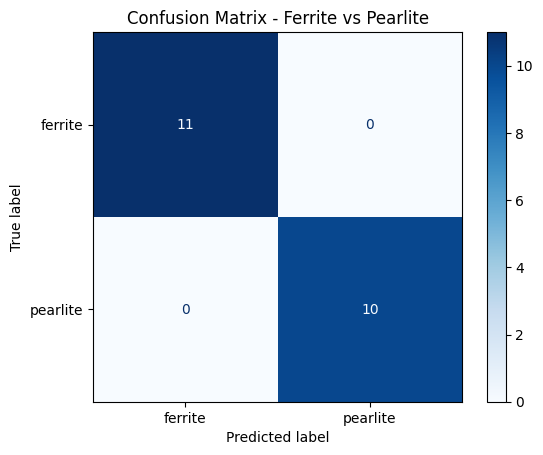

              precision    recall  f1-score   support

     ferrite       1.00      1.00      1.00        11
    pearlite       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [ ]:

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'dataset/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

loss, acc = model.evaluate(test_gen)
print(f'Test Accuracy: {acc*100:.2f}% | Loss: {loss:.4f}')

y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype('int32')
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Ferrite vs Pearlite')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

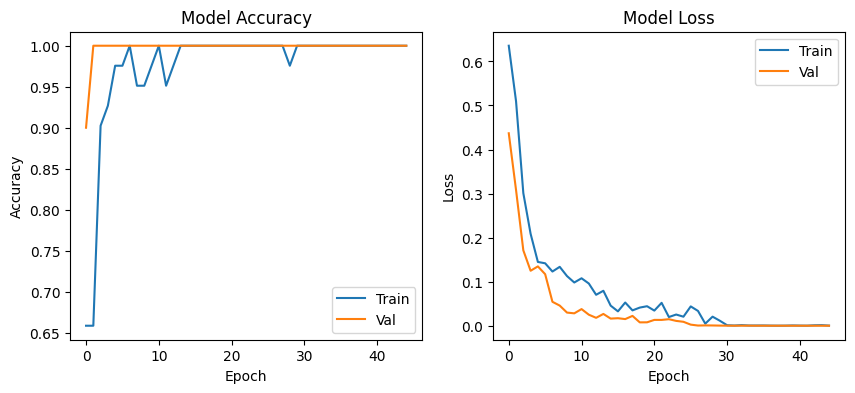

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'])
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/tmp/ipython-input-1628784609.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_labels[int(preds[idx])]


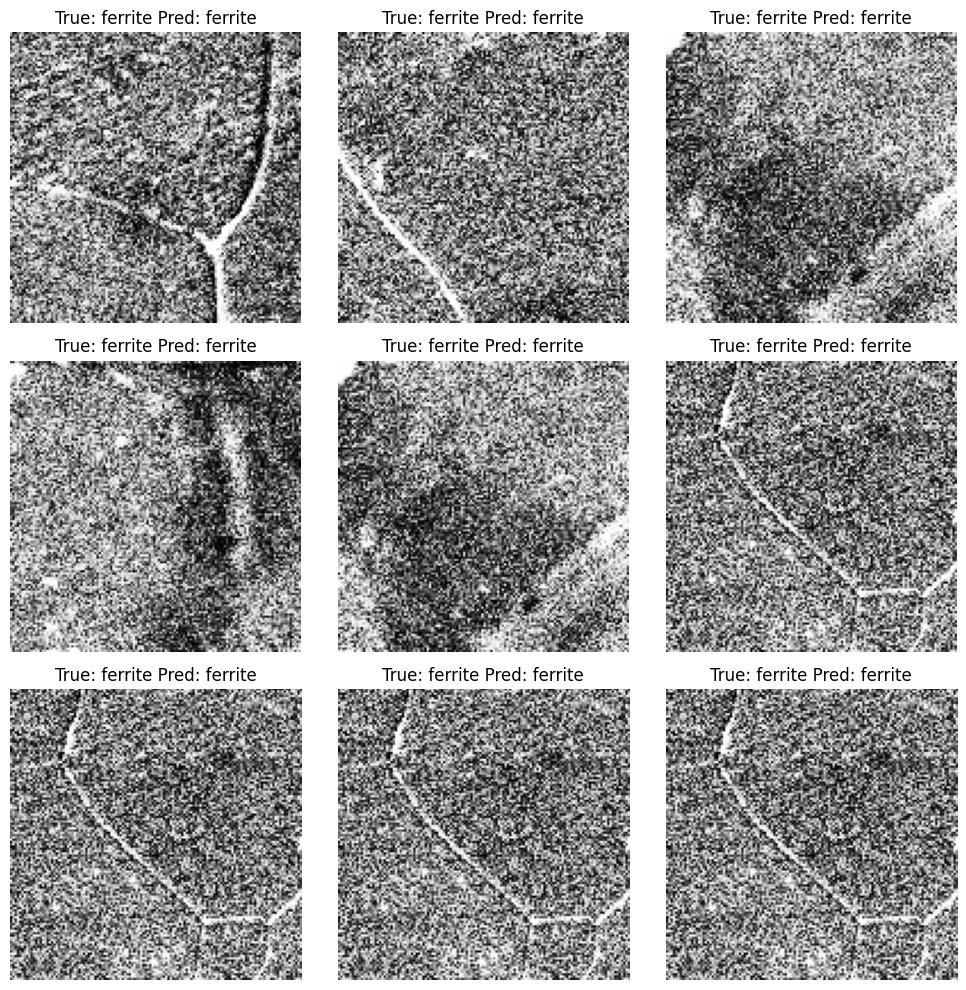

In [ ]:

import matplotlib.pyplot as plt

class_labels = list(test_gen.class_indices.keys())
images, labels = next(test_gen)
preds = (model.predict(images) > 0.5).astype('int32')

plt.figure(figsize=(10,10))
for i in range(9):
    idx = random.randint(0, len(images)-1)
    img = images[idx]
    true_label = class_labels[int(labels[idx])]
    pred_label = class_labels[int(preds[idx])]
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'True: {true_label} Pred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
from tensorflow.keras.utils import load_img, img_to_array

img = load_img("dataset/test/ferrite/ferr.28.jpg", target_size=(128,128))
# img = load_img("dataset/test/pearlite/parlite.28.jpg", target_size=(128,128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)[0][0]
print("Predicted:", "pearlite" if pred>0.5 else "ferrite")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Predicted: ferrite
